In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_path = '/kaggle/input/malerial-cell-classification-dataset/cell_images/cell_images'

In [3]:
train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size = (128,128),
    batch_size = 32,
    label_mode = 'int',
    validation_split = 0.2,
    subset = 'training',
    seed = 42
)

val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size = (128,128),
    batch_size = 32,
    label_mode = 'int',
    validation_split = 0.2,
    subset = 'validation',
    seed = 42
)

print(f'Class Names: {train.class_names}')

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.
Class Names: ['Parasitized', 'Uninfected']


In [4]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)/255.0
    return image, tf.one_hot(label, depth=2)

train = train.map(preprocess).prefetch(tf.data.AUTOTUNE)
val = val.map(preprocess).prefetch(tf.data.AUTOTUNE)

In [5]:
model = Sequential([
    Conv2D(16,(3,3), padding='valid', activation='relu',input_shape=(224,224,3)),
    MaxPooling2D(pool_size = (2,2),strides = (2,2), padding='same'),

    Conv2D(32, (3, 3), padding="valid", activation="relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    Conv2D(64, (3, 3), padding="valid", activation="relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    GlobalAveragePooling2D(),
    Dropout(0.5),
    BatchNormalization(),

    Dense(2, activation='softmax')
])

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-4),
    metrics=['Accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,970 (93.63 KB)

 Trainable params: 23,842 (93.13 KB)

 Non-trainable params: 128 (512.00 B)

In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [7]:
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 182s 261ms/step - Accuracy: 0.5578 - loss: 0.7240 - val_Accuracy: 0.6690 - val_loss: 0.6287
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 172s 250ms/step - Accuracy: 0.6699 - loss: 0.6231 - val_Accuracy: 0.6995 - val_loss: 0.5972
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 170s 247ms/step - Accuracy: 0.7177 - loss: 0.5857 - val_Accuracy: 0.8046 - val_loss: 0.5125
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 170s 247ms/step - Accuracy: 0.7948 - loss: 0.5075 - val_Accuracy: 0.8766 - val_loss: 0.3939
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 167s 242ms/step - Accuracy: 0.8545 - loss: 0.3966 - val_Accuracy: 0.9060 - val_loss: 0.3034
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 167s 243ms/step - Accuracy: 0.8857 - loss: 0.3219 - val_Accuracy: 0.8935 - val_loss: 0.2754
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 176s 255ms/step - Accuracy: 0.9058 - loss: 0.2765 - val_Accuracy: 0.9247 - val_loss: 0.2209
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 176s 255ms/step - Accuracy: 0.9154 -

In [8]:
val_loss, val_acc = model.evaluate(val)
print(f"Validation Accuracy: {val_acc:.2f}")


173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - Accuracy: 0.9352 - loss: 0.1715
Validation Accuracy: 0.94


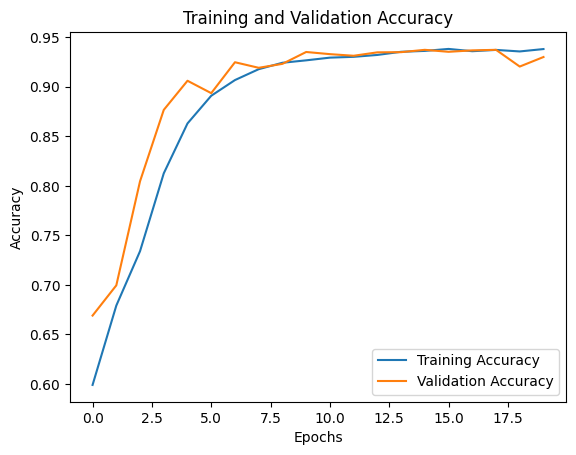

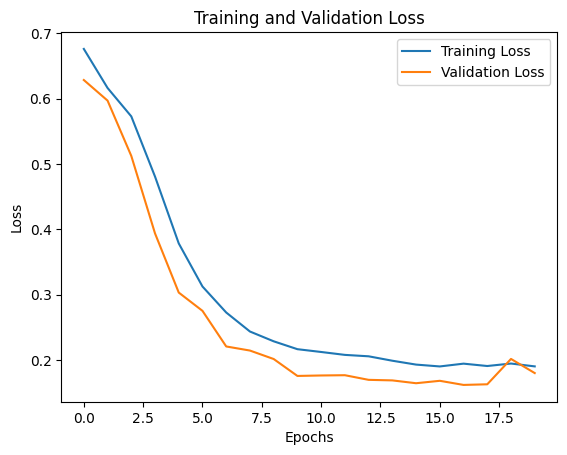

In [10]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['Accuracy'], label='Training Accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()


Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.
Class Names: ['Parasitized', 'Uninfected']
Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - accuracy: 0.4969 - loss: 0.6932 - val_accuracy: 0.4930 - val_loss: 0.6932
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.5031 - loss: 0.6931 - val_accuracy: 0.4930 - val_loss: 0.6932
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.5026 - loss: 0.6931 - val_accuracy: 0.4930 - val_loss: 0.6931
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.5050 - loss: 0.6931 - val_accuracy: 0.4930 - val_loss: 0.6931
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.5067 - loss: 0.6931 - val_accuracy: 0.4930 - val_loss: 0.6931
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.5066 - loss: 0.6930 - val_accuracy: 0.4930 - val_loss: 0.6931
Epoch 7/20
689/689 ━━━━━━━━━

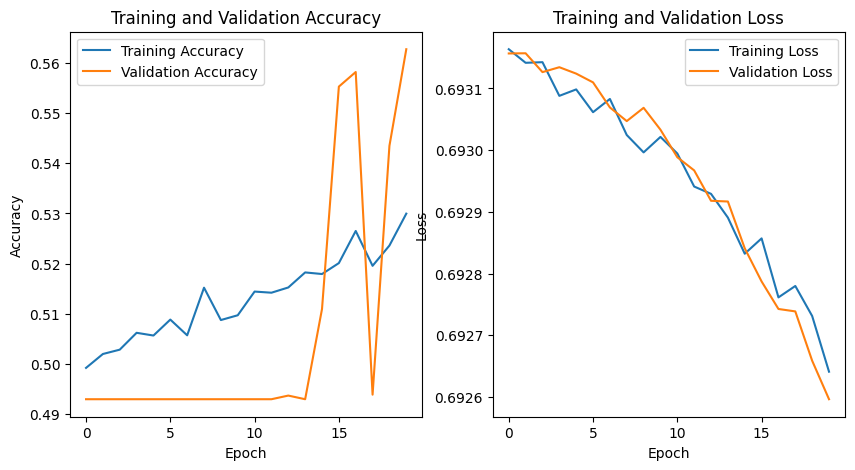

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = '/kaggle/input/malerial-cell-classification-dataset/cell_images/cell_images'

# Load the dataset with training and validation splits
train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(128, 128),
    batch_size=32,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=42
)

val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(128, 128),
    batch_size=32,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=42
)

# Save the class names before mapping the dataset
class_names = train.class_names
print(f'Class Names: {class_names}')

# Normalize the image data to improve model training performance
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
train = train.map(lambda x, y: (normalization_layer(x), y))
val = val.map(lambda x, y: (normalization_layer(x), y))

# Load MobileNetV2 with pretrained ImageNet weights
weights_path = '/kaggle/input/mobilenetv2-weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5'
base_model = VGG16(weights=None, include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train, validation_data=val, epochs=20, callbacks=[early_stopping])

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val)
print(f'\nValidation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Plotting training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(10, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Call the plot function
plot_history(history)
